In [1]:
# for loading packages
import pandas as pd

# for mathematical calculations
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# to build and evaluate model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# read train and test csv files 
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

What to do?
* Read data
* Exploratory data analysis
* Data cleaning and preprocessing
* Feature selection
* Model building
* Submission

### Reading data

In [2]:
# Make copy of datasets,
# So that changes will not affect the original datasets
train_set1 = df_train.copy()
test_set1 = df_test.copy()

In [3]:
# Head and tail info
train_set1.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Checking columns for train dataset
train_set1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [5]:
# Checking columns for test dataset
test_set1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [6]:
# Saving target column, will be used after preprocessing step
target = train_set1['Transported']

# Join test and train set to make clean process easier
train_set1 = train_set1.drop(['Transported'], axis=1)
data = pd.concat([train_set1, test_set1], axis=0).reset_index(drop=True)

In [7]:
# Train set info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


In [8]:
# Checking null values
data.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
dtype: int64

<Axes: >

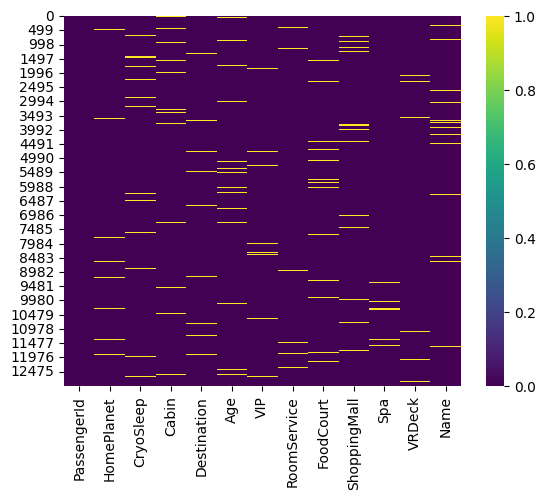

In [9]:
sns.heatmap(data=data.isnull(), cmap='viridis')

In [10]:
# Replacing missing object-type values with mode()
list_missing_cols = list((data.select_dtypes(['object', 'category']).isna().sum() > 0).index)

for col in list_missing_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

data.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age             270
VIP               0
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name              0
dtype: int64

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


<Axes: >

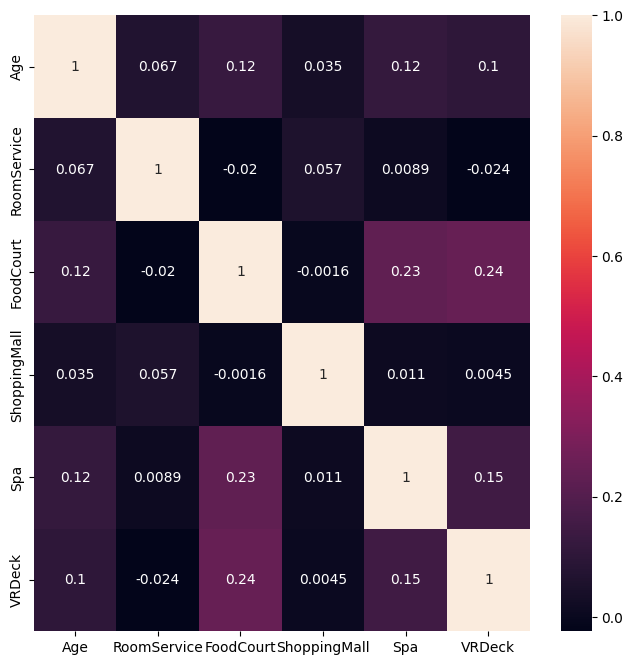

In [11]:
# Let's examine the data and try to find correlations
non_numeric_cols = list((data.select_dtypes(exclude='float64')))
print(non_numeric_cols)

temp_df = data.copy()

for col in non_numeric_cols:
    temp_df = temp_df.drop(col, axis=1)

plt.figure(figsize=(8, 8))
sns.heatmap(temp_df.corr(), annot=True)

"\n    Inferences: \n    If a person's age is lower than 13 or is in CryoSleep, amenities are all equal to 0\n    Where Age < 13 or CryoSleep == True, set RoomService = 0\n    Where Age < 13 or CryoSleep == True, set FoodCourt = 0\n    Where Age < 13 or CryoSleep == True, set ShoppingMall = 0\n    Where Age < 13 or CryoSleep == True, set Spa = 0\n    Where Age < 13 or CryoSleep == True, set VRDeck = 0\n"

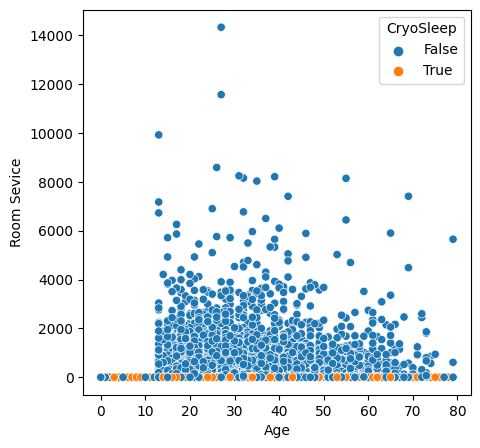

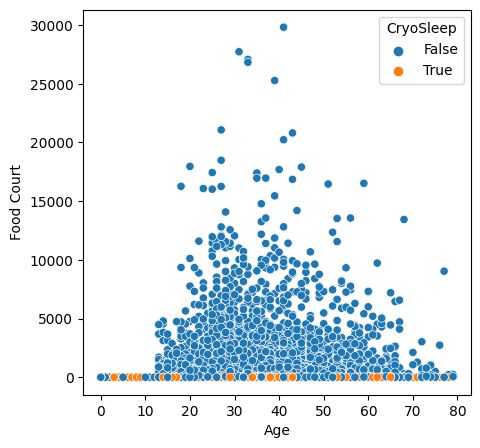

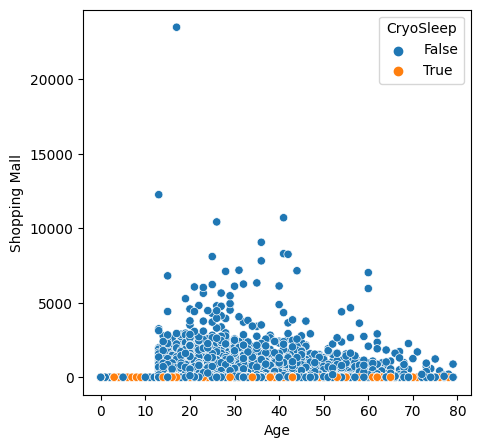

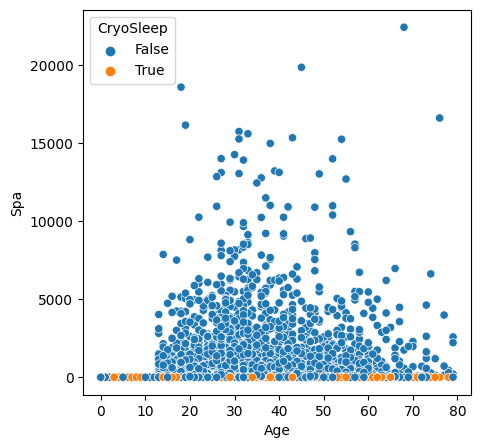

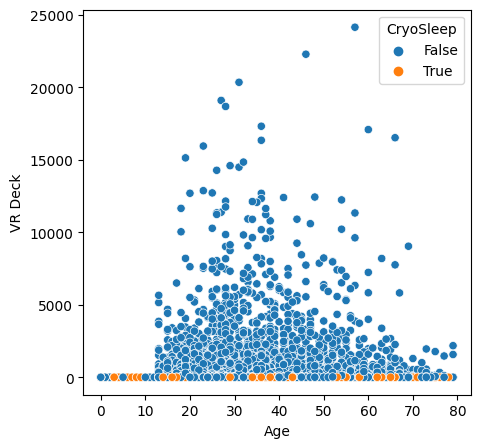

In [12]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'Age', y = 'RoomService', hue='CryoSleep', data=data)
plt.xlabel('Age')
plt.ylabel('Room Sevice')

plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'Age', y = 'FoodCourt', hue='CryoSleep', data=data)
plt.xlabel('Age')
plt.ylabel('Food Court')

plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'Age', y = 'ShoppingMall', hue='CryoSleep', data=data)
plt.xlabel('Age')
plt.ylabel('Shopping Mall')

plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'Age', y = 'Spa', hue='CryoSleep', data=data)
plt.xlabel('Age')
plt.ylabel('Spa')

plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'Age', y = 'VRDeck', hue='CryoSleep', data=data)
plt.xlabel('Age')
plt.ylabel('VR Deck')

"""
    Inferences: 
    If a person's age is lower than 13 or is in CryoSleep, amenities are all equal to 0
    Where Age < 13 or CryoSleep == True, set RoomService = 0
    Where Age < 13 or CryoSleep == True, set FoodCourt = 0
    Where Age < 13 or CryoSleep == True, set ShoppingMall = 0
    Where Age < 13 or CryoSleep == True, set Spa = 0
    Where Age < 13 or CryoSleep == True, set VRDeck = 0
"""

In [13]:
# Defining a function which sets NaNs by Age and CryoSleep values
def fill_nans_by_age_and_cryosleep(df):
    df['RoomService'] = np.where((df['Age'] < 13) | (df['CryoSleep'] == True), 0, df['RoomService'])
    df['FoodCourt'] = np.where((df['Age'] < 13) | (df['CryoSleep'] == True), 0, df['FoodCourt'])
    df['ShoppingMall'] = np.where((df['Age'] < 13) | (df['CryoSleep'] == True), 0, df['ShoppingMall'])
    df['Spa'] = np.where((df['Age'] < 13) | (df['CryoSleep'] == True), 0, df['Spa'])
    df['VRDeck'] = np.where((df['Age'] < 13) | (df['CryoSleep'] == True), 0, df['VRDeck'])

fill_nans_by_age_and_cryosleep(data)

In [14]:
# Now, lets fill the remaining missing values with using mean()
list_missing_numeric_cols = list((data.select_dtypes(np.number).isna().sum() > 0).index)

#print(list_missing_numeric_cols)
for col in list_missing_numeric_cols:
    data[col] = data[col].fillna(data[col].mean())

data.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

In [15]:
"""
PassengerId, Name columns will be dropped (check)
HomePlanet, CryoSleep, VIP, Destination columns will be get dummied (check) 
Cabin will be splitted into deck and side columns
"""
# Create CabinDeck feature
data['CabinDeck'] = data['Cabin'].str.split('/', expand=True)[0]

# Create CabinSide feature
data['CabinSide'] = data['Cabin'].str.split('/', expand=True)[2]

# Drop the irrelevant columns 
data = data.drop(['PassengerId'], axis=1)
data = data.drop(['Name'], axis=1)
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S


In [16]:
dummies = []
cols = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'CabinDeck', 'CabinSide']

for col in cols:
    dummies.append(pd.get_dummies(data[col], prefix=col).astype(int))
    
df_dummies = pd.concat(dummies, axis=1)
data = pd.concat((data, df_dummies), axis=1)

data = data.drop(['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Cabin', 'CabinDeck', 'CabinSide'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        12970 non-null  float64
 1   RoomService                12970 non-null  float64
 2   FoodCourt                  12970 non-null  float64
 3   ShoppingMall               12970 non-null  float64
 4   Spa                        12970 non-null  float64
 5   VRDeck                     12970 non-null  float64
 6   HomePlanet_Earth           12970 non-null  int64  
 7   HomePlanet_Europa          12970 non-null  int64  
 8   HomePlanet_Mars            12970 non-null  int64  
 9   CryoSleep_False            12970 non-null  int64  
 10  CryoSleep_True             12970 non-null  int64  
 11  VIP_False                  12970 non-null  int64  
 12  VIP_True                   12970 non-null  int64  
 13  Destination_55 Cancri e    12970 non-null  int

In [17]:
data.shape

(12970, 26)

In [18]:
# Now we can split the data into training and testing sets
data_2 = data.copy()

# Get the original index values of sets, and split
train_data_final = data_2.loc[:df_train.index.max(),  :].copy()
test_data_final = data_2.loc[df_train.index.max() + 1:, :].reset_index(drop = True).copy()

In [19]:
train_data_final.shape, test_data_final.shape, target.shape

((8693, 26), (4277, 26), (8693,))

In [20]:
# Model building
X = train_data_final.copy() # X_train
        
y = target.copy() # y_train

rf = RandomForestClassifier(random_state=1)
rf.fit(X, y)

result_final = cross_val_score(rf, X, y, cv = 20, scoring = "accuracy")

In [21]:
print(np.mean(result_final))
print(np.std(result_final))

0.7944345569150909
0.021456306581503163


In [22]:
# The result can be improved by using GridSearch algorithm
# which basically tries every combination of max tree depth and esimator
# this step is called Hyper Parameter Tuning
param_grid = { 'max_depth': list(range(1, 20, 2)),
              'n_estimators': list(range(1, 200, 20))}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid)

grid_search.fit(X, y)
grid_search.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=81, random_state=1)

In [23]:
# Applying the optimal parameters
model_final = RandomForestClassifier(max_depth=9, n_estimators=81, random_state=1)

model_final.fit(X, y)

RandomForestClassifier(max_depth=9, n_estimators=81, random_state=1)

In [24]:
result_final = cross_val_score(model_final, X, y, cv=20, scoring='accuracy')

print(np.mean(result_final))
print(np.std(result_final))

0.8006520472482652
0.021606333851833737


In [25]:
# Before submission, check the form of sample submission
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [26]:
# Get the predictions and concat necessary columns
prediction = model_final.predict(test_data_final)

pred_dict = {'PassangerId': test_set1['PassengerId'], 'Transported': prediction}
pred_df = pd.DataFrame(pred_dict)

pred_df.to_csv("titanic_submission.csv", index = False)

<Axes: >

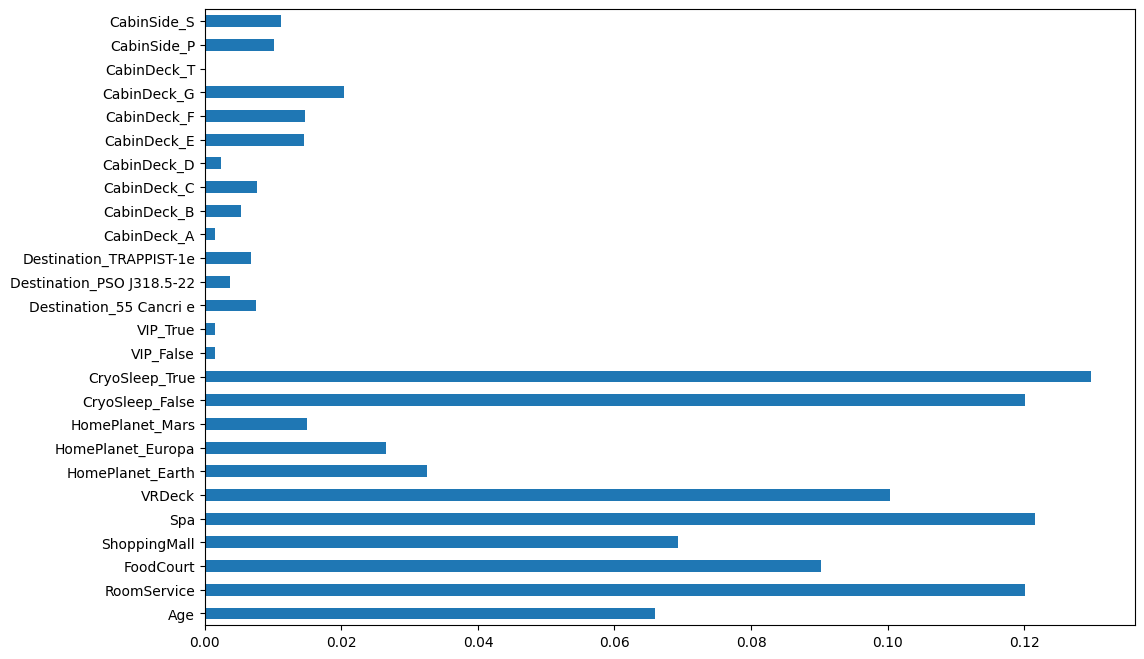

In [28]:
# Plot feature importances
# CryoSleep and amenities (RoomService, Spa and VRDeck) are the most important features in our dataset
importances = pd.Series(model_final.feature_importances_, index = X.columns)
importances.plot(kind = 'barh', figsize = (12, 8))